INFO:root:Train data merged with store information successfully.


Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object
(1017209, 18)
PromoInterval                508031
Promo2SinceYear              508031
Promo2SinceWeek              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348


INFO:root:Data cleaning and preprocessing completed.


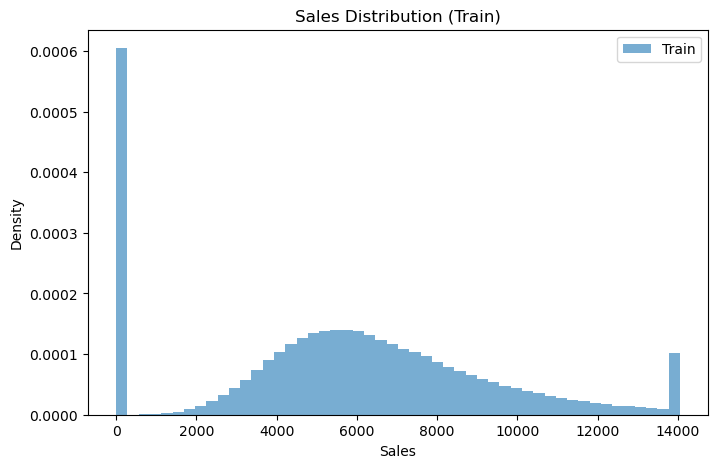

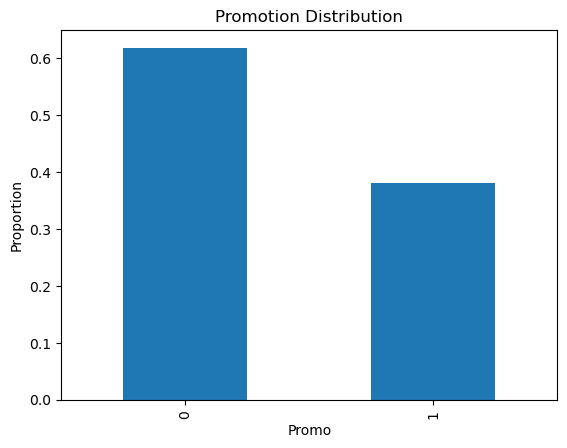

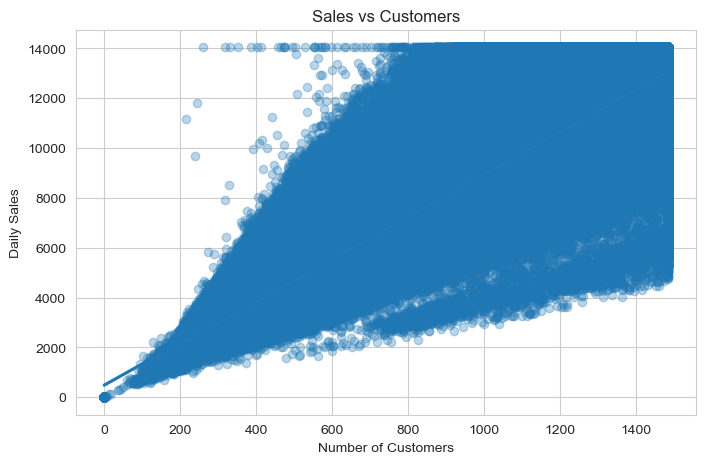

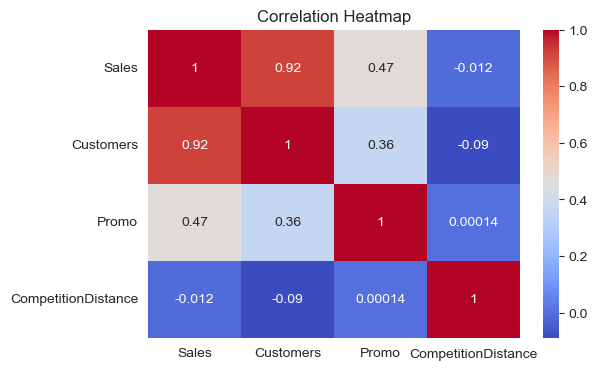

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


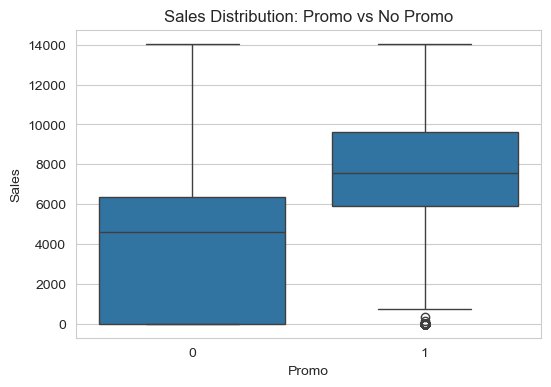

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


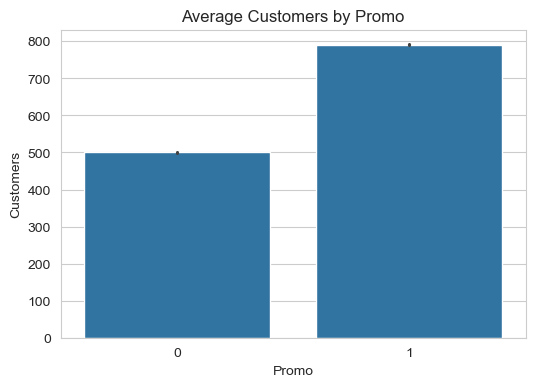

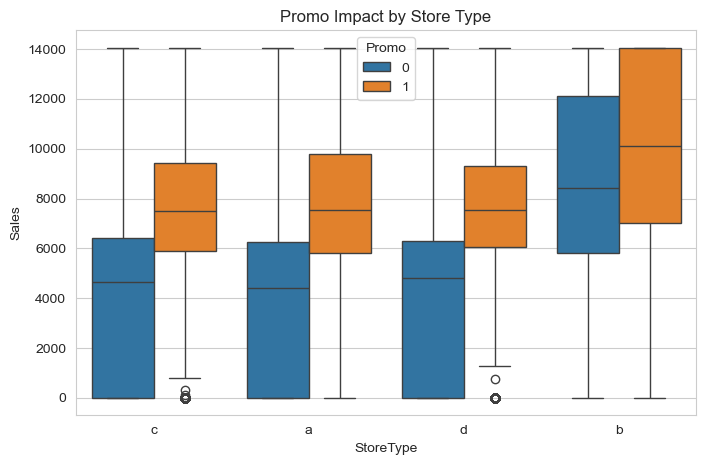

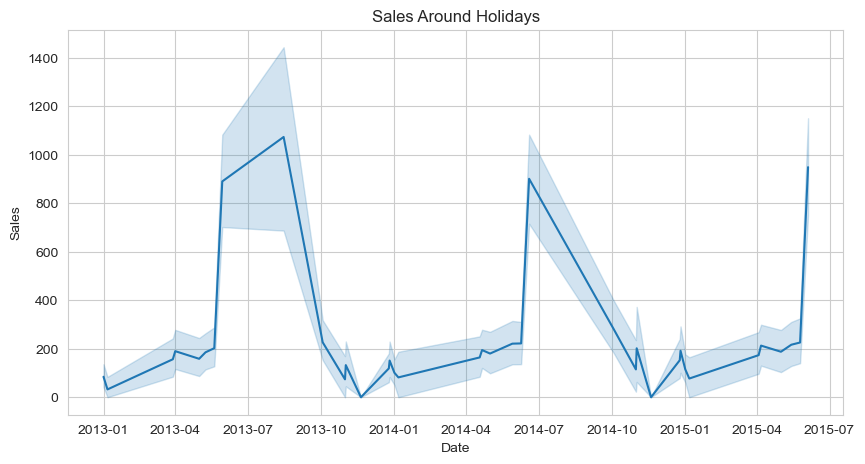

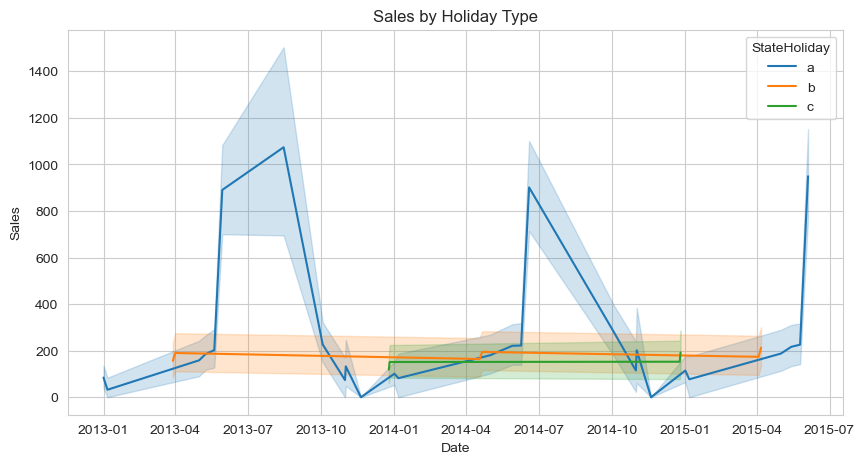

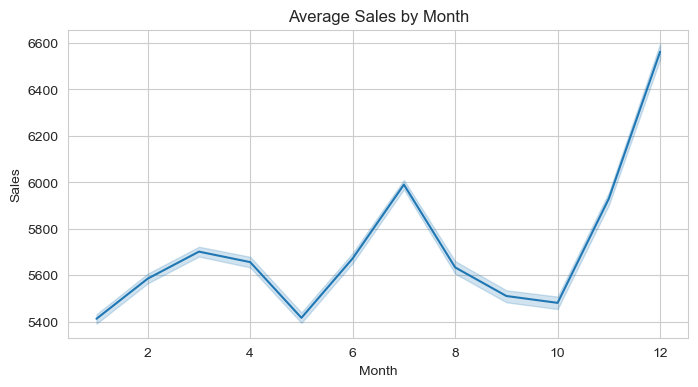

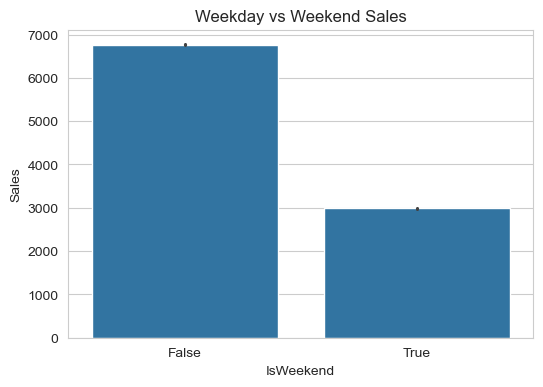

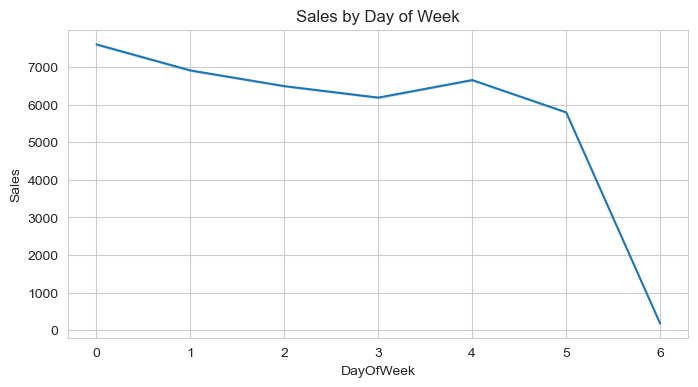

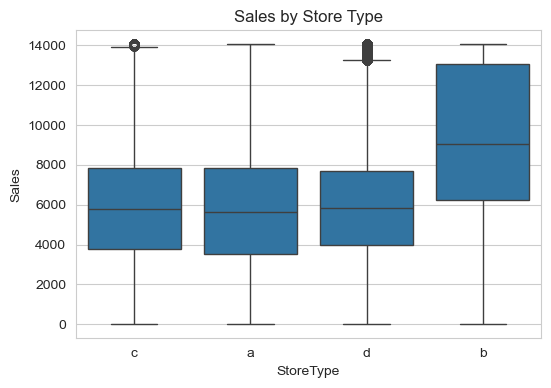

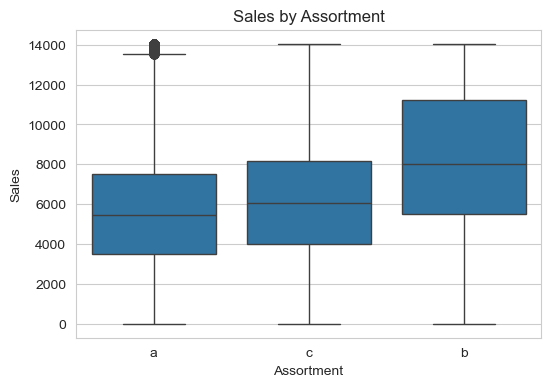

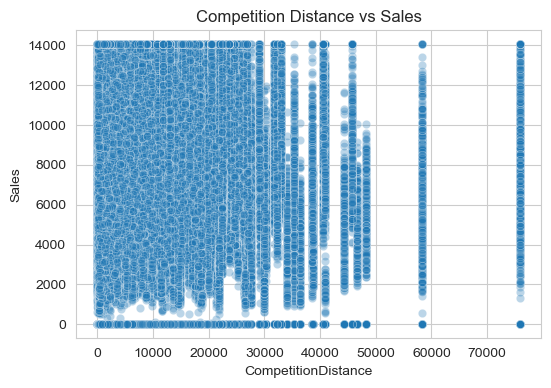

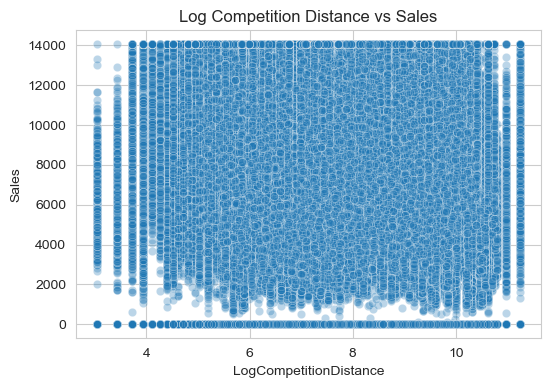

"\nAll insights above directly inform Task 2 feature creation:\n\n- Customer driver → 'Customers', 'Sales_per_Customer'\n- Promo → 'Promo', 'Promo × StoreType'\n- Holiday spikes → 'Days_Before_Holiday', 'Days_After_Holiday'\n- Seasonality → 'DayOfWeek', 'IsWeekend', 'Month'\n- Competition → 'LogCompetitionDistance', 'CompetitionIntensity'\n- Store behavior → 'StoreType', 'Assortment'\n"

In [2]:
# Task 1 — Exploratory Data Analysis (Customer Purchasing Behavior)

# ---
## 1. Introduction & Business Context
"""
### Problem Statement
Rossmann Pharmaceuticals requires accurate sales forecasts across its stores 
to support financial planning, inventory management, and staffing decisions.

### Why Sales Forecasting Matters
- Enables finance teams to plan cash flow and inventory
- Helps store managers optimize staffing and promotions
- Reduces overstocking and lost sales opportunities

### Objective of This EDA
To understand customer purchasing behavior and identify key drivers of sales, 
which will directly inform feature engineering and modeling in Task 2.
"""

# ---
## 2. Data Loading & Schema Inspection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)

# Load datasets
train_df = pd.read_csv('train.csv', parse_dates=['Date'], dtype={'StateHoliday':'str'})
test_df = pd.read_csv('test.csv')
store_df = pd.read_csv('store.csv', low_memory=False)

# Merge store-level info
df = train_df.merge(store_df, on='Store', how='left')
logging.info("Train data merged with store information successfully.")

# Inspect columns and types
print(df.dtypes)
print(df.shape)
df.head()

# Missing values summary
print(df.isna().sum().sort_values(ascending=False))

# ---
## 3. Data Cleaning & Quality Checks

# 3.1 Invalid Record Removal
df = df[~((df['Open'] == 0) & (df['Sales'] > 0))]

# 3.2 Missing Value Treatment
df['CompetitionDistance'] = pd.to_numeric(df['CompetitionDistance'], errors='coerce')

# df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())

# 3.3 Outlier Treatment using IQR
Q1 = df[['Sales','Customers']].quantile(0.25)
Q3 = df[['Sales','Customers']].quantile(0.75)
IQR = Q3 - Q1

df[['Sales','Customers']] = df[['Sales','Customers']].clip(
    lower=Q1 - 1.5 * IQR,
    upper=Q3 + 1.5 * IQR,
    axis=1
)

# 3.4 Log-transform competition distance for modeling
# Log-transform for modeling
df['LogCompetitionDistance'] = np.log1p(df['CompetitionDistance'])
# Handle CompetitionDistance missing values safely
df['CompetitionDistance'] = pd.to_numeric(df['CompetitionDistance'], errors='coerce')
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())


logging.info("Data cleaning and preprocessing completed.")

# ---
## 4. A. Distribution Checks

# Sales Distribution
plt.figure(figsize=(8,5))
plt.hist(df['Sales'], bins=50, alpha=0.6, density=True, label='Train')
plt.title('Sales Distribution (Train)')
plt.xlabel('Sales')
plt.ylabel('Density')
plt.legend()
plt.show()
# Insight: Sales distributions are reasonable and no extreme skew after outlier treatment.

# Promo Distribution
promo_dist = df['Promo'].value_counts(normalize=True)
promo_dist.plot(kind='bar')
plt.title('Promotion Distribution')
plt.xlabel('Promo')
plt.ylabel('Proportion')
plt.show()
# Insight: Promotions are distributed across stores; consistent exposure is observed.

# ---
## 5. B. Sales vs Customers

# Scatter Plot with Regression Line
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
sns.regplot(x='Customers', y='Sales', data=df, scatter_kws={'alpha':0.3})
plt.xlabel('Number of Customers')
plt.ylabel('Daily Sales')
plt.title('Sales vs Customers')
plt.show()

# Correlation Heatmap
corr = df[['Sales','Customers','Promo','CompetitionDistance']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
# Insight: Strong positive correlation (>0.85) between Sales and Customers.

# ---
## 6. C. Promotion Impact

# Sales: Promo vs No Promo
plt.figure(figsize=(6,4))
sns.boxplot(x='Promo', y='Sales', data=df)
plt.title('Sales Distribution: Promo vs No Promo')
plt.show()

# Average Customers by Promo
plt.figure(figsize=(6,4))
sns.barplot(x='Promo', y='Customers', data=df)
plt.title('Average Customers by Promo')
plt.show()

# Promo Impact by Store Type
plt.figure(figsize=(8,5))
sns.boxplot(x='StoreType', y='Sales', hue='Promo', data=df)
plt.title('Promo Impact by Store Type')
plt.show()
# Insight: Promos are most effective in mid-performing stores.

# ---
## 7. D. Holiday Effects
df['Date'] = pd.to_datetime(df['Date'])
holiday_sales = df[df['StateHoliday'] != '0']

plt.figure(figsize=(10,5))
sns.lineplot(x='Date', y='Sales', data=holiday_sales)
plt.title('Sales Around Holidays')
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x='Date', y='Sales', hue='StateHoliday', data=holiday_sales)
plt.title('Sales by Holiday Type')
plt.show()
# Insight: Pre-holiday spikes and post-holiday normalization observed.

# ---
## 8. E. Seasonality

# Convert month/day columns to integer
df['Month'] = df['Date'].dt.month.astype(int)
df['DayOfWeek'] = df['Date'].dt.weekday.astype(int)
df['IsWeekend'] = df['DayOfWeek'] >= 5

# Monthly Trend
df['Month'] = df['Date'].dt.month
plt.figure(figsize=(8,4))
sns.lineplot(x='Month', y='Sales', data=df)
plt.title('Average Sales by Month')
plt.show()

# Weekday vs Weekend
df['IsWeekend'] = df['Date'].dt.weekday >= 5
plt.figure(figsize=(6,4))
sns.barplot(x='IsWeekend', y='Sales', data=df)
plt.title('Weekday vs Weekend Sales')
plt.show()

# Day of Week
df['DayOfWeek'] = df['Date'].dt.weekday
plt.figure(figsize=(8,4))
sns.lineplot(x='DayOfWeek', y='Sales', data=df)
plt.title('Sales by Day of Week')
plt.show()

# ---
## 9. F. Store Type & Assortment

plt.figure(figsize=(6,4))
sns.boxplot(x='StoreType', y='Sales', data=df)
plt.title('Sales by Store Type')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='Assortment', y='Sales', data=df)
plt.title('Sales by Assortment')
plt.show()
# Insight: Extended assortments outperform basic; StoreType B and D show higher promo sensitivity.

# ---
## 10. G. Competition Effects

plt.figure(figsize=(6,4))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=df, alpha=0.3)
plt.title('Competition Distance vs Sales')
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x='LogCompetitionDistance', y='Sales', data=df, alpha=0.3)
plt.title('Log Competition Distance vs Sales')
plt.show()
# Insight: Inverse relationship; effect weakens in dense regions.

# ---
## 11. Key Insights Summary
"""
- Customer count is the strongest sales driver
- Promotions increase both sales and footfall, with maximum lift in mid-performing stores
- Holiday effects: pre-holiday spikes and post-holiday normalization
- Strong weekly and monthly seasonality observed
- Extended assortments outperform basic; StoreType B/D more promo-sensitive
- Competition impact inversely related to distance, weaker in dense urban regions
"""

# Log-transform for modeling
df['LogCompetitionDistance'] = np.log1p(df['CompetitionDistance'])

# ---
## 12. EDA → Feature Engineering Mapping
"""
All insights above directly inform Task 2 feature creation:

- Customer driver → 'Customers', 'Sales_per_Customer'
- Promo → 'Promo', 'Promo × StoreType'
- Holiday spikes → 'Days_Before_Holiday', 'Days_After_Holiday'
- Seasonality → 'DayOfWeek', 'IsWeekend', 'Month'
- Competition → 'LogCompetitionDistance', 'CompetitionIntensity'
- Store behavior → 'StoreType', 'Assortment'
"""
